<a href="https://colab.research.google.com/github/BURHANUDDIN51-PYTHON/fastai-under-the-hood/blob/main/02_titanic_tabular_from_scratch_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build the Titanic Surivival predictor

Things to do:-
1. Do the feature engineering
2. Build the linear model using the (element wise multiplicaton)
3. Build a simple neural net using the torch only from scratch
4. Then at last build a deep neural net with torch from scratch

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp -r kaggle.json ../root/.config/kaggle/
!chmod 600 ../root/.config/kaggle/kaggle.json
!pip install kaggle

In [ ]:
# Download the dataset
!kaggle competitions download -c titanic
!unzip titanic.zip -d titanic

In [ ]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [ ]:
from pathlib import Path
path = Path('titanic')

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)

<Axes: >

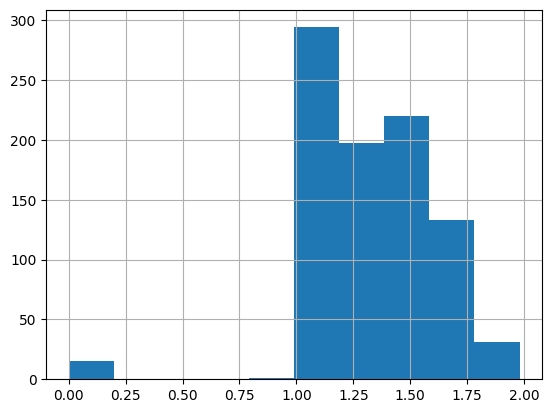

In [ ]:
# Normalize the data
df['Fare'] = np.log(df.Fare + 1)
df.Fare.hist()

In [ ]:
# One hot encoding
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [ ]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


In [ ]:
# Setup the dependent and the independent variable
from torch import tensor
dep_var = tensor(df.Survived)
indep_cols = ['Age', 'SibSp', 'Parch', 'Fare'] + added_cols
indep_var = np.array(df[indep_cols].values).astype(float)
indep_var = tensor(indep_var).float()

In [ ]:
# Normalize the indep values
val, idx = indep_var.max(dim=0)
indep_var = indep_var / val

In [ ]:
# Setup the coeffcient
n_coeff = indep_var.shape[1]

In [ ]:
n_coeff

12

In [ ]:
def init_params(n_coeff, n_hidden=20):
  layer1 = (torch.rand(n_coeff, n_hidden)-0.5) / n_hidden
  layer2 = torch.rand((n_hidden, 1))-0.3
  const = torch.rand(1)[0]
  return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [ ]:
import torch.nn.functional as F

In [ ]:
# calcPredicitons, upadateCoeffs, train model
def calc_predict(coeffs, indep):
  l1,l2,const = coeffs
  res = F.relu(indep@l1)
  res = (res@l2) + const
  return torch.sigmoid(res)

In [ ]:
def update_coeff(coeffs, lr):
  for layer in coeffs:
    layer.sub_(layer.grad * lr)
    layer.grad.zero_()

In [ ]:
def calc_loss(coeffs, indeps, deps):
  return torch.abs(calc_predict(coeffs, indeps)-deps).mean()

In [ ]:
def train_model(epochs=30, lr=2):
  torch.manual_seed(442)
  coeffs = init_params(n_coeff)
  for _ in range(epochs):
    loss = calc_loss(coeffs, indep_var, dep_var)
    loss.backward()
    with torch.no_grad(): update_coeff(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
  return coeffs

In [ ]:
trained_coeffs = train_model(lr=1.4)

0.542; 0.536; 0.531; 0.525; 0.518; 0.511; 0.503; 0.495; 0.485; 0.476; 0.465; 0.454; 0.444; 0.435; 0.426; 0.419; 0.414; 0.409; 0.405; 0.402; 0.400; 0.398; 0.396; 0.395; 0.394; 0.393; 0.392; 0.391; 0.391; 0.390; 

In [ ]:
def calculate_accuracy(coeffs, dep):
  preds = calc_predict(coeffs, indep_var)
  correct_answer = (dep.bool()==(preds>0.5)).float().mean()
  return correct_answer

In [ ]:
calculate_accuracy(trained_coeffs, dep_var)

tensor(0.6162)

# Basic structure of training a deep learning model
1. Set up the data
2. Define the parameters (weights and bias)
3. Calculate the predictions
4. Calculate the loss based on the predictions
5. Calculate the gradients
6. Update the paramters and the bias using the gradients and the learning rate
7. Repeat the process till you want, or you end up with the resources

In [ ]:
# Create a whole neural net from scratch
from torch import tensor
import torch.nn.functional as F

class NeuralNet():
  def __init__(self, n_coeff, hidden_layers, indep_var, dep_var):
    size = [n_coeff] + hidden_layers + [1]
    self.n = len(size)
    self.indep_var = indep_var
    self.dep_var = dep_var
    self.layers = [
        (torch.rand(size[i], size[i+1])-0.5) / size[i+1]*4
        for i in range(self.n-1)
    ]
    self.consts = [
        (torch.rand(1)[0]-0.5)*0.1 for i in range(self.n-1)
    ]
    # Enable Gradients
    for l in self.layers + self.consts: l.requires_grad_()


  # Getters
  def get_coeffs(self):
    return self.layers, self.consts

  # Private Methods
  def _calc_pred(self):
    res = self.indep_var
    for i, l in enumerate(self.layers):
      res = res@l + self.consts[i]
      if i != self.n-1: res = F.relu(res)
    return torch.sigmoid(res)

  def _calc_loss(self):
    predictions = self._calc_pred()
    return (torch.abs(predictions-self.dep_var)**2).float().mean()

  def _accuracy(self):
    pred = self._calc_pred()
    return (self.dep_var.bool()==(pred>0.5)).float().mean()

  # Public Methods
  def train(self, epochs=5, lr=0.1):
    for _ in range(epochs):
      loss = self._calc_loss()
      loss.backward()
      with torch.no_grad():
        for layer in self.layers + self.consts:
          layer.sub_(layer.grad * lr)
          layer.grad.zero_()
      print(f"\n Epoch:{_+1} \n LOSS: {loss} \n ACCURACY: {self._accuracy()}")



In [ ]:
net = NeuralNet(n_coeff, [20,20], indep_var, dep_var)

In [ ]:
net.train()